In [60]:
# Import necessary libraries
import logging
import pathlib
import re
from typing import Tuple, List
from collections import Counter

import gensim.downloader as api
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Initialize logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
X_train_file = pathlib.Path("data/X_train_G3tdtEn.csv")
y_train_file = pathlib.Path("data/Y_train_2_XPXJDyy.csv")
X_test_file = pathlib.Path("data/X_test_8skS2ey.csv")

In [4]:
# Define the Word2Vec transformer class
class W2V(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=None, **kwargs):
        self.num_words = num_words
        self.tokenizer = Tokenizer(num_words=num_words, **kwargs)

    def fit(self, X, y=None):
        self.Word2 = api.load("word2vec-google-news-300")
        return self

    def transform(self, X, y=None):
        x = np.array(X.values)
        for i in range(len(x)):
            for j in range(len(x[i])):
                tokens = x[i][j].split()
                embeddings = [
                    self.Word2[token]
                    for token in tokens
                    if token in self.Word2.key_to_index
                ]
                if len(embeddings) > 0:
                    mean = np.mean(embeddings)
                else:
                    mean = 0
                x[i][j] = mean
        return x

    def get_params(self, deep=True):
        return {"num_words": self.num_words}

In [5]:
def load_train_df(path: pathlib.Path) -> pd.DataFrame:
    mixed_columns = (
        ["item" + str(i) for i in range(1, 25)]
        + ["make" + str(i) for i in range(1, 25)]
        + ["model" + str(i) for i in range(1, 25)]
        + ["goods_code" + str(i) for i in range(1, 25)]
    )
    dtype = {col: str for col in mixed_columns}
    return pd.read_csv(path, dtype=dtype)


def load_test_df(path: pathlib.Path) -> pd.Series:
    return pd.read_csv(path)["fraud_flag"]

In [83]:
def df_to_input(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str]]:
    # Add feature columns
    # df["total_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].sum(axis=1)
    # df["avg_item_price"] = df["total_price"] / df["Nb_of_items"]
    # df["max_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].max(axis=1)
    # df["min_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].min(axis=1)
    # df["product_count"] = df[[f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]].sum(
    #     axis=1
    # )
    # df["nb_unique_makes"] = df[[f"make{i}" for i in range(1, 25)]].nunique(axis=1)
    # df["nb_unique_models"] = df[[f"model{i}" for i in range(1, 25)]].nunique(axis=1)
    # Most common item in the purchase.
    # df["most_common_item"] = df[
    #     [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]
    # ].idxmax(axis=1)
    # most_common_item = []
    # for _, row in df.iterrows():
    #     match = re.search(r"(\d+)", row["most_common_item"])
    #     item_number = int(match.group(1))
    #     most_common_item.append(row[f"item{item_number}"])
    # df["most_common_item"] = most_common_item
    # df["most_common_item"] = df["most_common_item"].astype(str)

    # all_goods = []
    # for _, row in df.iterrows():
    #     for i in range(1, 25):
    #         all_goods.append(row[f"goods_code{i}"])
    # goods_counter = Counter(all_goods)
    # for index, row in df.iterrows():
    #     for i in range(1, 25):
    #         if isinstance(row[f"goods_code{i}"], str):
    #             df.at[index, f"goods_code{i}"] = goods_counter[row[f"goods_code{i}"]]
    #         else:
    #             df.at[index, f"goods_code{i}"] = 0
    # df[["goods_code" + str(i) for i in range(1, 25)]] = df[["goods_code" + str(i) for i in range(1, 25)]].astype(int)
    to_drop = ["ID"] + [f"goods_code{i}" for i in range(1, 25)]
    df = df.drop(to_drop, axis=1)

    # Identify the columns to apply RNN tokenization
    categorical_columns = ["make", "item", "model"]  # Add more columns as needed
    categorical_columns = [
        col + str(i) for col in categorical_columns for i in range(1, 25)
    ]
    # categorical_columns.append("most_common_item")

    # Identify the categorical and numerical columns
    numerical_columns = [
        col for col in df.columns if col not in set(categorical_columns)
    ]

    # Clean data
    for col in categorical_columns:
        df[col] = df[col].fillna("")
    for col in numerical_columns:
        df[col] = df[col].fillna(0)

    return df, categorical_columns, numerical_columns

In [84]:
X_train_df = load_train_df(X_train_file)
y_train_df = load_test_df(y_train_file)

X_train_df, categorical_columns, numerical_columns = df_to_input(X_train_df)

In [89]:
# Define transformers
cat_pipeline = make_pipeline(W2V())
num_pipeline = make_pipeline(StandardScaler())


# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipeline", cat_pipeline, categorical_columns),
        ("num_pipeline", num_pipeline, numerical_columns),
    ]
)

# clf = linear_model.LogisticRegression(
#     solver="saga", class_weight="balanced"
# )

clf = RandomForestClassifier(
    random_state=0, max_depth=20, n_estimators=400, n_jobs=-1
)

# Create the pipeline
pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", clf)], verbose=True)

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, test_size=0.2, stratify=y_train_df, random_state=0
)
print(y_train.value_counts()[1] / len(y_train))
print(y_test.value_counts()[1] / len(y_test))

# param_grid = {
#     "model__n_estimators": [400, 500, 700],
#     # "max_features": ["auto", "sqrt", "log2"],
#     "model__max_depth": [10, 20, 30],
#     # "criterion": ["gini", "entropy"],
# }

# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# grid = GridSearchCV(
#     pipeline,
#     param_grid,
#     scoring="average_precision",
#     cv=sss,
#     n_jobs=-1,
#     verbose=True,
# )

0.014212199590473111
0.014225670869705788


In [90]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-22T13:00:53.975461', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=  24.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=   2.1s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('w2v',
                                                                   W2V())]),
                                                  ['make1', 'make2', 'make3',
                                                   'make4', 'make5', 'make6',
                                                   'make7', 'make8', 'make9',
                                                   'make10', 'make11', 'make12',
                                                   'make13', 'make14', 'make15',
                                                   'make16', 'make17', 'make18',
                                                   'make19', 'make20', 'make21',
                                                   'make22', 'make23', 'make24',
                                                   'item1', 'item2', 'item3',
                                                   'item4',...
                                                   'cash_price18',
                                                   'cash_price19',
                                                   'cash_price20',
                                                   'cash_price21',
                                                   'cash_price22',
                                                   'cash_price23',
                                                   'cash_price24',
                                                   'Nbr_of_prod_purchas1',
                                                   'Nbr_of_prod_purchas2',
                                                   'Nbr_of_prod_purchas3',
                                                   'Nbr_of_prod_purchas4',
                                                   'Nbr_of_prod_purchas5',
                                                   'Nbr_of_prod_purchas6', ...])])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=400,
                                        n_jobs=-1, random_state=0))],
         verbose=True)

0.03262621363979269


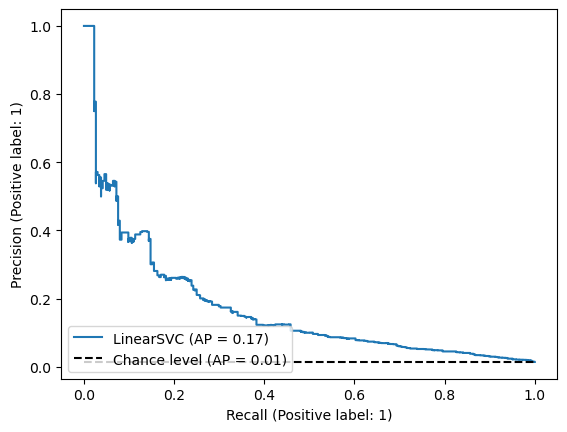

In [91]:
print(metrics.average_precision_score(y_test, pipeline.predict(X_test)))
display = metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name="LinearSVC", plot_chance_level=True
)

In [45]:
print(grid.best_params_)
print(grid.best_score_)

{'model__max_depth': 20, 'model__n_estimators': 400}
0.18999914433325743


In [47]:
X_test_df = load_train_df(X_test_file)
X_test_df, _, _ = df_to_input(X_test_df)

In [55]:
best_params = {k.replace("model__", ""): v for k, v in grid.best_params_.items()}

In [61]:
best_params

{'max_depth': 20, 'n_estimators': 400}

In [56]:
full_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(random_state=0, **best_params)),
    ],
    verbose=True,
)

In [60]:
print(X_test_df.shape)
print(X_train_df.shape)

(23198, 121)
(92790, 121)


In [64]:
out = full_pipeline.fit(X_train_df, y_train_df).predict_proba(X_test_df)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-13T22:50:01.476979', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


[Pipeline] ........ (step 1 of 2) Processing preprocess, total=  25.3s
[Pipeline] ............. (step 2 of 2) Processing model, total=  16.6s


In [68]:
out_ = out[:, 1]
IDs = pd.read_csv(X_test_file)["ID"]
df = pd.DataFrame({"ID": IDs, "fraud_flag": out_})
df = df.reset_index()
df.to_csv("out.csv", index=False)
df.describe()

/var/folders/m8/1pn02zvd5rn8khdmf1r7t7sc0000gn/T/ipykernel_25684/3316615219.py:2: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  IDs = pd.read_csv(X_test_file)["ID"]


,index,ID,fraud_flag
count,23198.000000,23198.000000,23198.000000
mean,11598.500000,58091.621605,0.014031
std,6696.830108,33465.131873,0.036607
min,0.000000,3.000000,0.000000
25%,5799.250000,29355.500000,0.000515
50%,11598.500000,58128.000000,0.003159
75%,17397.750000,87016.750000,0.015065
max,23197.000000,115987.000000,0.968746


In [ ]:
df["fraud_flag"].hist()